In [1]:
# Urban Heat Island Analysis - Berlin
# Author: Medhansh Ahuja
# Course: Applications 2 – Urban Technologies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print("Urban Heat Berlin Jupyter Notebook Started Successfully!")

Urban Heat Berlin Jupyter Notebook Started Successfully!


In [2]:
pip install osmnx

Note: you may need to restart the kernel to use updated packages.


In [3]:
import osmnx as ox
import geopandas as gpd

# Download Berlin city boundary
berlin = ox.geocode_to_gdf("Berlin, Germany")

print("Berlin boundary loaded successfully!")
berlin

Berlin boundary loaded successfully!


,geometry,bbox_west,bbox_south,bbox_east,bbox_north,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name
0,"MULTIPOLYGON (((13.08834 52.41963, 13.09021 52...",13.088345,52.338245,13.761161,52.675509,134060781,relation,62422,52.517389,13.395131,boundary,administrative,8,0.840425,city,Berlin,"Berlin, Germany"


In [4]:
# Download Berlin districts (Bezirke) from OpenStreetMap - OSMnx 2.x compatible

districts = ox.features_from_place(
    "Berlin, Germany",
    tags={"boundary": "administrative", "admin_level": "8"}
)

print("Raw OSM district objects:", len(districts))
districts.head()

Raw OSM district objects: 197


geometry  \
element  id                                                         
relation 16328  POLYGON ((13.30038 52.56998, 13.3019 52.57144,...   
         16330  POLYGON ((13.26423 52.62686, 13.26438 52.62802...   
         16334  POLYGON ((13.2082 52.59899, 13.20724 52.59987,...   
         16343  POLYGON ((13.10932 52.45071, 13.10956 52.45108...   
         16346  POLYGON ((13.27034 52.54934, 13.27061 52.54934...   

                      boundary                 name  ref admin_level name:ab  \
element  id                                                                    
relation 16328  administrative        Reinickendorf  NaN          10     NaN   
         16330  administrative              Frohnau  NaN          10     NaN   
         16334  administrative        Reinickendorf  NaN           9     NaN   
         16343  administrative              Spandau  NaN           9     NaN   
         16346  administrative  Charlottenburg-Nord  NaN          10     NaN   

               name:af name:als name:am name:an  ... name:prefix:city  \
element  id                                      ...                    
relation 16328     NaN      NaN     NaN     NaN  ...              NaN   
         16330     NaN      NaN     NaN     NaN  ...              NaN   
         16334     NaN      NaN     NaN     NaN  ...              NaN   
         16343     NaN      NaN     NaN     NaN  ...              NaN   
         16346     NaN      NaN     NaN     NaN  ...              NaN   

               name:prefix:state ref:nuts:1 ref:nuts:2  \
element  id                                              
relation 16328               NaN        NaN        NaN   
         16330               NaN        NaN        NaN   
         16334               NaN        NaN        NaN   
         16343               NaN        NaN        NaN   
         16346               NaN        NaN        NaN   

               report_problems:website state_code alt_name:cs alt_name:pt  \
element  id                                                                 
relation 16328                     NaN        NaN         NaN         NaN   
         16330                     NaN        NaN         NaN         NaN   
         16334                     NaN        NaN         NaN         NaN   
         16343                     NaN        NaN         NaN         NaN   
         16346                     NaN        NaN         NaN         NaN   

               ref:old admin_centre:postal_code  
element  id                                      
relation 16328     NaN                      NaN  
         16330     NaN                      NaN  
         16334     NaN                      NaN  
         16343     NaN                      NaN  
         16346     NaN                      NaN  

[5 rows x 391 columns]

In [5]:
# Keep only polygon geometries (real district boundaries)
districts_clean = districts[districts.geometry.type.isin(["Polygon", "MultiPolygon"])].copy()
districts_clean = districts_clean.reset_index(drop=True)

print("Clean district polygons:", len(districts_clean))
districts_clean[["name", "geometry"]].head()

Clean district polygons: 193


,name,geometry
0,Reinickendorf,"POLYGON ((13.30038 52.56998, 13.3019 52.57144,..."
1,Frohnau,"POLYGON ((13.26423 52.62686, 13.26438 52.62802..."
2,Reinickendorf,"POLYGON ((13.2082 52.59899, 13.20724 52.59987,..."
3,Spandau,"POLYGON ((13.10932 52.45071, 13.10956 52.45108..."
4,Charlottenburg-Nord,"POLYGON ((13.27034 52.54934, 13.27061 52.54934..."


In [6]:
# Inspect available admin levels
districts_clean["admin_level"].value_counts()

admin_level
10    98
9     40
8     26
11    16
6      9
4      2
2      1
7      1
Name: count, dtype: int64

In [7]:
# Official list of Berlin Bezirke
bezirke_namen = [
    "Mitte",
    "Friedrichshain-Kreuzberg",
    "Pankow",
    "Charlottenburg-Wilmersdorf",
    "Spandau",
    "Steglitz-Zehlendorf",
    "Tempelhof-Schöneberg",
    "Neukölln",
    "Treptow-Köpenick",
    "Marzahn-Hellersdorf",
    "Lichtenberg",
    "Reinickendorf"
]

# Keep only rows that match official Bezirk names
bezirke_raw = districts_clean[districts_clean["name"].isin(bezirke_namen)].copy()

print("Raw Bezirk parts (before dissolve):", len(bezirke_raw))
bezirke_raw["name"].value_counts()

Raw Bezirk parts (before dissolve): 18


name
Reinickendorf                 2
Spandau                       2
Mitte                         2
Neukölln                      2
Pankow                        2
Lichtenberg                   2
Steglitz-Zehlendorf           1
Treptow-Köpenick              1
Friedrichshain-Kreuzberg      1
Tempelhof-Schöneberg          1
Marzahn-Hellersdorf           1
Charlottenburg-Wilmersdorf    1
Name: count, dtype: int64

In [8]:
# Dissolve all fragments into one polygon per Bezirk
bezirke = bezirke_raw.dissolve(by="name", as_index=False)

print("Final Bezirke count:", len(bezirke))
bezirke[["name", "geometry"]]

Final Bezirke count: 12


,name,geometry
0,Charlottenburg-Wilmersdorf,"POLYGON ((13.18817 52.47184, 13.18829 52.47418..."
1,Friedrichshain-Kreuzberg,"POLYGON ((13.36858 52.49396, 13.36841 52.49448..."
2,Lichtenberg,"POLYGON ((13.51699 52.53541, 13.51706 52.53542..."
3,Marzahn-Hellersdorf,"POLYGON ((13.51688 52.53555, 13.51704 52.53556..."
4,Mitte,"POLYGON ((13.40419 52.5404, 13.4047 52.54019, ..."
5,Neukölln,"POLYGON ((13.39992 52.41854, 13.40012 52.41877..."
6,Pankow,"MULTIPOLYGON (((13.38845 52.56775, 13.38905 52..."
7,Reinickendorf,"POLYGON ((13.34913 52.5892, 13.34979 52.58891,..."
8,Spandau,"POLYGON ((13.10956 52.45108, 13.10973 52.45132..."
9,Steglitz-Zehlendorf,"POLYGON ((13.08834 52.41963, 13.09584 52.42198..."


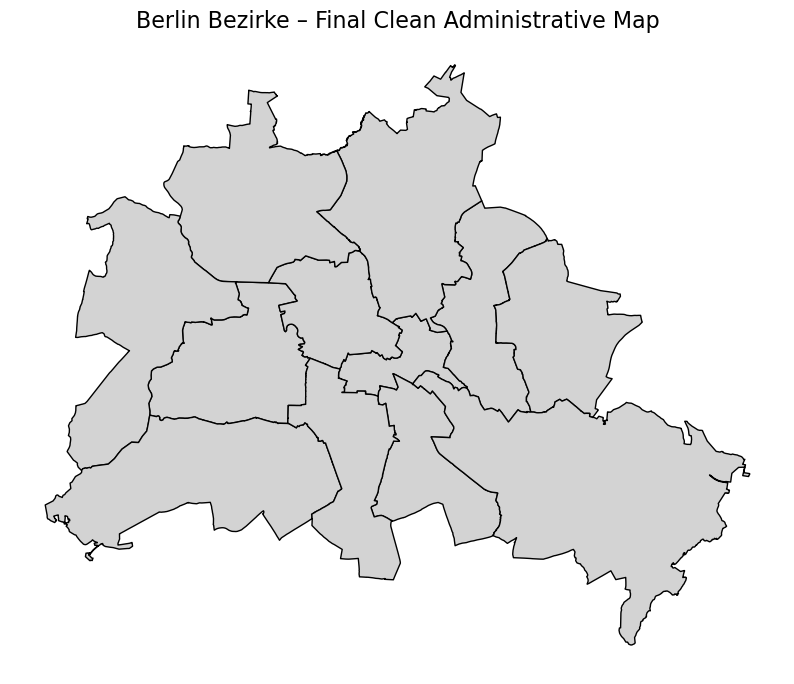

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
bezirke.plot(ax=ax, edgecolor="black", facecolor="lightgray")
ax.set_title("Berlin Bezirke – Final Clean Administrative Map", fontsize=16)
plt.axis("off")
plt.show()

In [10]:
from pathlib import Path
Path.cwd()

PosixPath('/Users/medhanshahuja/Projects/Urban Technology/Urban_Heat_Berlin_Project/code')

In [11]:
import geopandas as gpd
import osmnx as ox
print("geopandas:", gpd.__version__)
print("osmnx:", ox.__version__)

geopandas: 1.1.1
osmnx: 2.0.7


In [12]:
import geopandas as gpd

gdfs = {name: val for name, val in globals().items() if isinstance(val, gpd.GeoDataFrame)}
print("GeoDataFrames found:", list(gdfs.keys()))

print("\nCandidates with 12 rows:")
for name, gdf in gdfs.items():
    try:
        if len(gdf) == 12:
            print("-", name, "| CRS:", gdf.crs, "| columns:", list(gdf.columns))
    except Exception:
        pass

GeoDataFrames found: ['__', 'berlin', '_3', 'districts', '_4', 'districts_clean', '_5', 'bezirke_raw', 'bezirke', '_8']

Candidates with 12 rows:
- __ | CRS: epsg:4326 | columns: ['name', 'geometry']
- bezirke | CRS: epsg:4326 | columns: ['name', 'geometry', 'boundary', 'ref', 'admin_level', 'name:ab', 'name:af', 'name:als', 'name:am', 'name:an', 'name:ang', 'name:ar', 'name:arc', 'name:arz', 'name:ast', 'name:av', 'name:az', 'name:ba', 'name:bar', 'name:bat-smg', 'name:be', 'name:be-tarask', 'name:bg', 'name:bi', 'name:bn', 'name:bo', 'name:br', 'name:bs', 'name:bxr', 'name:ca', 'name:cbk-zam', 'name:ce', 'name:ckb', 'name:co', 'name:crh', 'name:cs', 'name:csb', 'name:cu', 'name:cv', 'name:cy', 'name:da', 'name:de', 'name:diq', 'name:dsb', 'name:el', 'name:en', 'name:eo', 'name:es', 'name:et', 'name:eu', 'name:ext', 'name:fa', 'name:fi', 'name:fo', 'name:fr', 'name:frp', 'name:fur', 'name:fy', 'name:ga', 'name:gan', 'name:gd', 'name:gl', 'name:gn', 'name:gu', 'name:gv', 'name:haw', 'n

In [13]:
print("rows:", len(bezirke))
print("crs:", bezirke.crs)
bezirke[["name"]].head()

rows: 12
crs: epsg:4326


,name
0,Charlottenburg-Wilmersdorf
1,Friedrichshain-Kreuzberg
2,Lichtenberg
3,Marzahn-Hellersdorf
4,Mitte


In [14]:
from pathlib import Path

out = Path("../data/processed/berlin_bezirke.geojson")
out.parent.mkdir(parents=True, exist_ok=True)

bezirke.to_file(out, driver="GeoJSON")

print("Saved to:", out.resolve())
print("Exists:", out.exists())

Saved to: /Users/medhanshahuja/Projects/Urban Technology/Urban_Heat_Berlin_Project/data/processed/berlin_bezirke.geojson
Exists: True


In [15]:
## Air temperature (DWD) – Bezirk indicators + maps

In [16]:
from pathlib import Path
import re, io, zipfile
import requests

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

def find_repo_root(start=None) -> Path:
    start = (Path(start) if start else Path.cwd()).resolve()
    for p in [start] + list(start.parents):
        if (p / ".git").exists():
            return p
    return start

ROOT = find_repo_root()
DATA_RAW = ROOT / "data" / "raw" / "dwd_airtemp_hourly"
DATA_PROCESSED = ROOT / "data" / "processed"
MAPS_DIR = ROOT / "maps"
REPORT_DIR = ROOT / "report"

for d in [DATA_RAW, DATA_PROCESSED, MAPS_DIR, REPORT_DIR]:
    d.mkdir(parents=True, exist_ok=True)

ROOT

PosixPath('/Users/medhanshahuja/Projects/Urban Technology/Urban_Heat_Berlin_Project')

In [17]:
DATE_START = "2024-06-01"
DATE_END   = "2024-08-31"

BUFFER_M = 50000  # 50 km buffer around Berlin (helps ensure enough stations)

DWD_BASE = "https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/air_temperature"
DWD_DIR = "historical"  # stable snapshot (recommended for reproducibility)
STATIONS_TXT = "TU_Stundenwerte_Beschreibung_Stationen.txt"

In [18]:
bezirke_path = DATA_PROCESSED / "berlin_bezirke.geojson"
bezirke = gpd.read_file(bezirke_path)

print("Columns:", list(bezirke.columns))

bezirke = bezirke.to_crs(25833)  # meters (good for distances)

# Auto-detect a likely district name column
candidates = [c for c in bezirke.columns if c.lower() in ["bezirk", "bezirk_name", "district", "name", "borough"]]
if not candidates:
    obj_cols = [c for c in bezirke.columns if c != "geometry" and bezirke[c].dtype == "object"]
    candidates = obj_cols[:1]

BEZIRK_COL = candidates[0]
print("Using BEZIRK_COL =", BEZIRK_COL)

bezirke[[BEZIRK_COL, "geometry"]].head()

Columns: ['name', 'boundary', 'ref', 'admin_level', 'name:ab', 'name:af', 'name:als', 'name:am', 'name:an', 'name:ang', 'name:ar', 'name:arc', 'name:arz', 'name:ast', 'name:av', 'name:az', 'name:ba', 'name:bar', 'name:bat-smg', 'name:be', 'name:be-tarask', 'name:bg', 'name:bi', 'name:bn', 'name:bo', 'name:br', 'name:bs', 'name:bxr', 'name:ca', 'name:cbk-zam', 'name:ce', 'name:ckb', 'name:co', 'name:crh', 'name:cs', 'name:csb', 'name:cu', 'name:cv', 'name:cy', 'name:da', 'name:de', 'name:diq', 'name:dsb', 'name:el', 'name:en', 'name:eo', 'name:es', 'name:et', 'name:eu', 'name:ext', 'name:fa', 'name:fi', 'name:fo', 'name:fr', 'name:frp', 'name:fur', 'name:fy', 'name:ga', 'name:gan', 'name:gd', 'name:gl', 'name:gn', 'name:gu', 'name:gv', 'name:haw', 'name:he', 'name:hi', 'name:hr', 'name:hsb', 'name:ht', 'name:hu', 'name:hy', 'name:ia', 'name:id', 'name:ie', 'name:ilo', 'name:io', 'name:is', 'name:it', 'name:iu', 'name:ja', 'name:jbo', 'name:jv', 'name:ka', 'name:kab', 'name:kbd', 'name:k

,name,geometry
0,Charlottenburg-Wilmersdorf,"POLYGON ((376933.967 5815062.735, 376948.661 5..."
1,Friedrichshain-Kreuzberg,"POLYGON ((389242.922 5817230.692, 389232.973 5..."
2,Lichtenberg,"POLYGON ((399412.454 5821624.502, 399417.577 5..."
3,Marzahn-Hellersdorf,"POLYGON ((399405.646 5821639.564, 399416.022 5..."
4,Mitte,"POLYGON ((391774.531 5822342.44, 391808.848 58..."


In [19]:
try:
    berlin_union = bezirke.geometry.union_all()  # shapely 2
except Exception:
    berlin_union = bezirke.geometry.unary_union  # older shapely

berlin_buffer = gpd.GeoSeries([berlin_union], crs=bezirke.crs).buffer(BUFFER_M).iloc[0]

In [20]:
stations_meta_path = DATA_RAW / STATIONS_TXT
stations_url = f"{DWD_BASE}/{DWD_DIR}/{STATIONS_TXT}"

def download_if_missing(url: str, path: Path) -> None:
    if path.exists():
        return
    r = requests.get(url, timeout=60)
    r.raise_for_status()
    path.write_bytes(r.content)

download_if_missing(stations_url, stations_meta_path)

stations_df = pd.read_fwf(stations_meta_path, encoding="latin-1")
stations_df.columns = [c.strip() for c in stations_df.columns]
print("Station metadata columns:", list(stations_df.columns))
stations_df.head()

Station metadata columns: ['Stations_id von_datum bis_datum', 'Stationshoehe geoBreite geoLaenge Stationsname Bundesland Abgabe', 'Unnamed: 2']


,Stations_id von_datum bis_datum,Stationshoehe geoBreite geoLaenge Stationsname Bundesland Abgabe,Unnamed: 2
0,----------- --------- ---------,------------- --------- --------- ------------...,NaN
1,00003 19500401 20110331,202 50.7827 6.0941 Aachen ...,Frei
2,00044 20070401 20260124,44 52.9336 8.2370 Großenkneten ...,Frei
3,00052 19760101 19880101,46 53.6623 10.1990 Ahrensburg-Wulfsdorf ...,Frei
4,00071 20091201 20191231,759 48.2156 8.9784 Albstadt-Badkap ...,Frei


In [21]:
# Re-parse the DWD station list robustly (fixes missing lat/lon)

text = stations_meta_path.read_text(encoding="latin-1", errors="replace").splitlines()

rows = []
pattern = re.compile(
    r"^\s*(\d{1,5})\s+(\d{8})\s+(\d{8})\s+(-?\d+)\s+(-?\d+(?:\.\d+)?)\s+(-?\d+(?:\.\d+)?)\s+(.*)$"
)

for line in text:
    m = pattern.match(line)
    if not m:
        continue
    station_id, von, bis, height, lat, lon, tail = m.groups()

    # Try to split tail into (name, state, status) when possible
    parts = tail.split()
    status = parts[-1] if parts and parts[-1].lower() in ["frei"] else None
    state = parts[-2] if status and len(parts) >= 2 else None
    name = " ".join(parts[:-2]) if status and len(parts) >= 3 else tail.strip()

    rows.append({
        "station_id": int(station_id),
        "von_datum": von,
        "bis_datum": bis,
        "height_m": int(height),
        "lat": float(lat),
        "lon": float(lon),
        "name": name,
        "state": state,
        "status": status
    })

stations_df = pd.DataFrame(rows)

print("Parsed rows:", len(stations_df))
print("Columns:", list(stations_df.columns))
stations_df.head()

Parsed rows: 667
Columns: ['station_id', 'von_datum', 'bis_datum', 'height_m', 'lat', 'lon', 'name', 'state', 'status']


,station_id,von_datum,bis_datum,height_m,lat,lon,name,state,status
0,3,19500401,20110331,202,50.7827,6.0941,Aachen,Nordrhein-Westfalen,Frei
1,44,20070401,20260124,44,52.9336,8.2370,Großenkneten,Niedersachsen,Frei
2,52,19760101,19880101,46,53.6623,10.1990,Ahrensburg-Wulfsdorf,Schleswig-Holstein,Frei
3,71,20091201,20191231,759,48.2156,8.9784,Albstadt-Badkap,Baden-Württemberg,Frei
4,73,20070401,20260124,374,48.6183,13.0620,Aldersbach-Kramersepp,Bayern,Frei


In [22]:
stations_gdf = gpd.GeoDataFrame(
    stations_df,
    geometry=gpd.points_from_xy(stations_df["lon"], stations_df["lat"]),
    crs=4326
).to_crs(bezirke.crs)

stations_berlin = stations_gdf[stations_gdf.geometry.within(berlin_buffer)].copy()
print("Stations selected:", len(stations_berlin))

stations_berlin[["station_id", "name", "lat", "lon"]].head()

Stations selected: 21


,station_id,name,lat,lon
7,96,Neuruppin-Alt Ruppin,52.9437,12.8518
34,303,Baruth,52.0613,13.4997
47,399,Berlin-Alexanderplatz,52.5198,13.4057
48,400,Berlin-Buch,52.6310,13.5021
49,403,Berlin-Dahlem (FU),52.4537,13.3017


In [23]:
hist_dir_url = f"{DWD_BASE}/{DWD_DIR}/"
html = requests.get(hist_dir_url, timeout=60).text

def parse_hist_zips_for_station(station_id: int, html_text: str):
    sid = f"{int(station_id):05d}"
    pattern = rf"(stundenwerte_TU_{sid}_(\d{{8}})_(\d{{8}})_hist\.zip)"
    return [(m.group(1), m.group(2), m.group(3)) for m in re.finditer(pattern, html_text)]

def choose_best_zip(files, date_start: str, date_end: str):
    ds = int(pd.to_datetime(date_start).strftime("%Y%m%d"))
    de = int(pd.to_datetime(date_end).strftime("%Y%m%d"))
    parsed = [(fn, int(a), int(b)) for fn, a, b in files]
    covering = [x for x in parsed if x[1] <= ds and x[2] >= de]
    if covering:
        return sorted(covering, key=lambda x: x[2], reverse=True)[0][0]
    return sorted(parsed, key=lambda x: x[2], reverse=True)[0][0] if parsed else None

stations_berlin["hist_zip"] = stations_berlin["station_id"].apply(
    lambda sid: choose_best_zip(parse_hist_zips_for_station(sid, html), DATE_START, DATE_END)
)

print("Stations with hist_zip:", stations_berlin["hist_zip"].notna().sum(), "out of", len(stations_berlin))
stations_berlin[["station_id", "name", "hist_zip"]].dropna().head()

Stations with hist_zip: 21 out of 21


,station_id,name,hist_zip
7,96,Neuruppin-Alt Ruppin,stundenwerte_TU_00096_20190409_20241231_hist.zip
34,303,Baruth,stundenwerte_TU_00303_19930819_20241231_hist.zip
47,399,Berlin-Alexanderplatz,stundenwerte_TU_00399_19691201_20110801_hist.zip
48,400,Berlin-Buch,stundenwerte_TU_00400_19910101_20241231_hist.zip
49,403,Berlin-Dahlem (FU),stundenwerte_TU_00403_20020101_20241231_hist.zip


In [24]:
stations_berlin_use = stations_berlin.dropna(subset=["hist_zip"]).copy()

def read_station_tt_tu_from_zip(zip_bytes: bytes) -> pd.DataFrame:
    with zipfile.ZipFile(io.BytesIO(zip_bytes)) as zf:
        prod = [n for n in zf.namelist() if n.lower().startswith("produkt_") and n.lower().endswith(".txt")][0]
        with zf.open(prod) as f:
            df = pd.read_csv(f, sep=";", na_values=[-999, -999.0])
    df["MESS_DATUM"] = pd.to_datetime(df["MESS_DATUM"], format="%Y%m%d%H")
    return df

def fetch_station_hourly(row) -> pd.DataFrame:
    zip_name = row["hist_zip"]
    url = f"{hist_dir_url}{zip_name}"
    local_zip = DATA_RAW / zip_name

    if local_zip.exists():
        zip_bytes = local_zip.read_bytes()
    else:
        r = requests.get(url, timeout=120)
        r.raise_for_status()
        zip_bytes = r.content
        local_zip.write_bytes(zip_bytes)

    df = read_station_tt_tu_from_zip(zip_bytes)
    df["station_id"] = int(row["station_id"])
    return df

dfs = []
for _, row in stations_berlin_use.iterrows():
    dfs.append(fetch_station_hourly(row))

hourly = pd.concat(dfs, ignore_index=True)

ts0 = pd.to_datetime(DATE_START)
ts1 = pd.to_datetime(DATE_END) + pd.Timedelta(days=1) - pd.Timedelta(hours=1)
hourly = hourly[(hourly["MESS_DATUM"] >= ts0) & (hourly["MESS_DATUM"] <= ts1)].copy()

print("Rows:", len(hourly))
print("Stations in hourly:", hourly["station_id"].nunique())
hourly[["station_id", "MESS_DATUM", "TT_TU"]].head()

Rows: 30912
Stations in hourly: 14


,station_id,MESS_DATUM,TT_TU
45111,96,2024-06-01 00:00:00,16.1
45112,96,2024-06-01 01:00:00,15.5
45113,96,2024-06-01 02:00:00,15.1
45114,96,2024-06-01 03:00:00,14.9
45115,96,2024-06-01 04:00:00,15.1


In [25]:
hourly["date"] = hourly["MESS_DATUM"].dt.date

daily = (hourly.groupby(["station_id", "date"], as_index=False)
         .agg(daily_max=("TT_TU", "max"),
              daily_mean=("TT_TU", "mean")))

station_metrics = (hourly.groupby("station_id", as_index=False)
                   .agg(mean_tt=("TT_TU", "mean"),
                        hot_hours_30=("TT_TU", lambda s: int((s >= 30).sum()))))

station_daily_metrics = (daily.groupby("station_id", as_index=False)
                         .agg(mean_daily_max=("daily_max", "mean"),
                              hot_days_30=("daily_max", lambda s: int((s >= 30).sum()))))

station_metrics = station_metrics.merge(station_daily_metrics, on="station_id", how="left")
station_metrics.head()

,station_id,mean_tt,hot_hours_30,mean_daily_max,hot_days_30
0,96,18.803578,37,24.229348,7
1,303,19.298370,59,25.351087,16
2,400,19.445471,46,24.981522,9
3,403,19.513859,43,24.743478,10
4,427,19.871552,40,25.039130,12


In [26]:
# Bezirk centroids (in meters)
bezirke_cent = bezirke[[BEZIRK_COL, "geometry"]].copy()
bezirke_cent["geometry"] = bezirke_cent.geometry.centroid

# Stations with metrics (same CRS)
stations_pts = stations_berlin_use.merge(station_metrics, on="station_id", how="inner")[[
    "station_id", "geometry", "mean_tt", "mean_daily_max", "hot_hours_30", "hot_days_30"
]].to_crs(bezirke_cent.crs)

# Beginner-friendly nearest match (brute force; ok because only 12 Bezirke)
nearest_station_ids = []
nearest_dist_m = []

for geom in bezirke_cent.geometry:
    d = stations_pts.distance(geom)
    idx = d.idxmin()
    nearest_station_ids.append(int(stations_pts.loc[idx, "station_id"]))
    nearest_dist_m.append(float(d.loc[idx]))

bez_join = bezirke_cent.copy()
bez_join["station_id"] = nearest_station_ids
bez_join["dist_m"] = nearest_dist_m

bez_join = bez_join.merge(stations_pts.drop(columns="geometry"), on="station_id", how="left")
bez_join[[BEZIRK_COL, "station_id", "dist_m", "mean_daily_max"]].head()

,name,station_id,dist_m,mean_daily_max
0,Charlottenburg-Wilmersdorf,403,5684.637275,24.743478
1,Friedrichshain-Kreuzberg,433,4406.706766,25.182609
2,Lichtenberg,433,10465.651530,25.182609
3,Marzahn-Hellersdorf,400,13285.727897,24.981522
4,Mitte,433,7663.835068,25.182609


In [27]:
bezirke_out = bezirke.merge(
    bez_join[[BEZIRK_COL, "mean_tt", "mean_daily_max", "hot_hours_30", "hot_days_30"]],
    on=BEZIRK_COL,
    how="left"
)

out_geojson = DATA_PROCESSED / "berlin_bezirke_airtemp_indicators.geojson"
out_csv = DATA_PROCESSED / "berlin_bezirke_airtemp_indicators.csv"

bezirke_out.to_file(out_geojson, driver="GeoJSON")
bezirke_out.drop(columns="geometry").to_csv(out_csv, index=False)

print(out_geojson)
print(out_csv)

/Users/medhanshahuja/Projects/Urban Technology/Urban_Heat_Berlin_Project/data/processed/berlin_bezirke_airtemp_indicators.geojson
/Users/medhanshahuja/Projects/Urban Technology/Urban_Heat_Berlin_Project/data/processed/berlin_bezirke_airtemp_indicators.csv


In [28]:
cols = [BEZIRK_COL, "mean_daily_max", "hot_days_30", "hot_hours_30", "mean_tt"]

print("Top 5 warmest Bezirke (mean_daily_max):")
display(bezirke_out[cols].sort_values("mean_daily_max", ascending=False).head(5))

print("Top 5 coolest Bezirke (mean_daily_max):")
display(bezirke_out[cols].sort_values("mean_daily_max", ascending=True).head(5))

Top 5 warmest Bezirke (mean_daily_max):


,name,mean_daily_max,hot_days_30,hot_hours_30,mean_tt
1,Friedrichshain-Kreuzberg,25.182609,11,48,20.309375
2,Lichtenberg,25.182609,11,48,20.309375
4,Mitte,25.182609,11,48,20.309375
5,Neukölln,25.182609,11,48,20.309375
10,Tempelhof-Schöneberg,25.182609,11,48,20.309375


Top 5 coolest Bezirke (mean_daily_max):


,name,mean_daily_max,hot_days_30,hot_hours_30,mean_tt
0,Charlottenburg-Wilmersdorf,24.743478,10,43,19.513859
8,Spandau,24.743478,10,43,19.513859
9,Steglitz-Zehlendorf,24.743478,10,43,19.513859
3,Marzahn-Hellersdorf,24.981522,9,46,19.445471
6,Pankow,24.981522,9,46,19.445471


In [29]:
bezirke_out[["mean_daily_max", "hot_days_30", "hot_hours_30", "mean_tt"]].describe()


,mean_daily_max,hot_days_30,hot_hours_30,mean_tt
count,12.000000,12.000000,12.000000,12.000000
mean,25.010598,10.333333,45.583333,19.858035
std,0.182246,0.984732,2.712206,0.413930
min,24.743478,9.000000,40.000000,19.445471
25%,24.922011,9.750000,43.000000,19.496762
50%,25.010326,10.500000,46.000000,19.692705
75%,25.182609,11.000000,48.000000,20.309375
max,25.182609,12.000000,48.000000,20.309375


In [30]:
def save_choropleth(gdf, column, title, out_path: Path):
    fig, ax = plt.subplots(figsize=(8, 8))
    gdf.plot(column=column, ax=ax, legend=True)
    ax.set_title(title)
    ax.set_axis_off()
    fig.tight_layout()
    fig.savefig(out_path, dpi=200)
    plt.close(fig)

save_choropleth(
    bezirke_out, "mean_daily_max",
    f"Berlin Bezirke – Mean Daily Max Air Temp (DWD TT_TU)\n{DATE_START} to {DATE_END}",
    MAPS_DIR / "berlin_airtemp_mean_daily_max.png"
)

save_choropleth(
    bezirke_out, "hot_days_30",
    f"Berlin Bezirke – Hot Days (Tmax ≥ 30°C)\n{DATE_START} to {DATE_END}",
    MAPS_DIR / "berlin_airtemp_hot_days_30.png"
)

list(MAPS_DIR.glob("berlin_airtemp_*.png"))

[PosixPath('/Users/medhanshahuja/Projects/Urban Technology/Urban_Heat_Berlin_Project/maps/berlin_airtemp_mean_daily_max.png'),
 PosixPath('/Users/medhanshahuja/Projects/Urban Technology/Urban_Heat_Berlin_Project/maps/berlin_airtemp_hot_days_30.png')]

In [31]:
# --- Build rankings + summary text, then write report/air_temperature_summary.md ---

# 1) Rank Bezirke by mean daily max (warmest -> coolest)
rank_tmax = bezirke_out[
    [BEZIRK_COL, "mean_daily_max", "hot_days_30", "hot_hours_30", "mean_tt"]
].sort_values("mean_daily_max", ascending=False)

warm3 = ", ".join(rank_tmax.head(3)[BEZIRK_COL].tolist())
cool3 = ", ".join(rank_tmax.tail(3)[BEZIRK_COL].tolist())

# 2) Ranges for quick interpretation
tmax_min = float(bezirke_out["mean_daily_max"].min())
tmax_max = float(bezirke_out["mean_daily_max"].max())

hotd_min = float(bezirke_out["hot_days_30"].min())
hotd_max = float(bezirke_out["hot_days_30"].max())

hoth_min = float(bezirke_out["hot_hours_30"].min())
hoth_max = float(bezirke_out["hot_hours_30"].max())

# 3) Rank Bezirke by hot days
rank_hotdays = bezirke_out[[BEZIRK_COL, "hot_days_30"]].sort_values("hot_days_30", ascending=False)
hotdays3 = ", ".join(rank_hotdays.head(3)[BEZIRK_COL].tolist())

# 4) Compose markdown summary
summary = "\n".join([
    "# Urban Heat Berlin — Air Temperature (DWD TT_TU)",
    f"Period: {DATE_START} to {DATE_END}",
    "",
    "## Key indicators (Bezirk-level; nearest-station baseline)",
    f"- Mean daily max range: {tmax_min:.2f}°C to {tmax_max:.2f}°C",
    f"- Hot days (Tmax ≥ 30°C) range: {hotd_min:.0f} to {hotd_max:.0f} days",
    f"- Hot hours (≥ 30°C) range: {hoth_min:.0f} to {hoth_max:.0f} hours",
    f"- Warmest Bezirke by mean daily max: {warm3}",
    f"- Coolest Bezirke by mean daily max: {cool3}",
    f"- Bezirke with most hot days (Tmax ≥ 30°C): {hotdays3}",
    "",
    "## Notes / limitations",
    "- Nearest-station assignment is a conservative baseline; it may miss microclimate differences within Bezirke.",
    "- Next upgrade: multi-station interpolation (e.g., inverse-distance weighting) and/or add land surface temperature (LST).",
])

# 5) Write report file
report_path = REPORT_DIR / "air_temperature_summary.md"
report_path.write_text(summary, encoding="utf-8")
report_path

PosixPath('/Users/medhanshahuja/Projects/Urban Technology/Urban_Heat_Berlin_Project/report/air_temperature_summary.md')

## Step 6 — Green space + population density vs heat (from processed features)

Pearson corr(Tmax, green_share_pct)     = 0.597
Pearson corr(Tmax, pop_density_ew_km2)  = 0.598


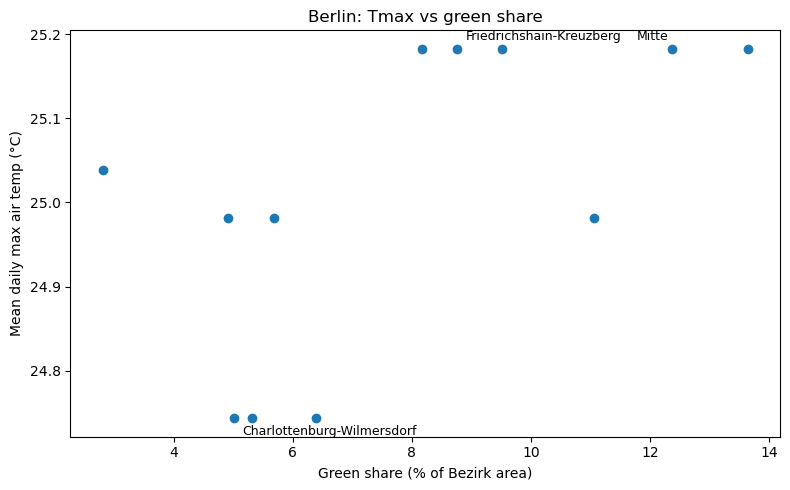

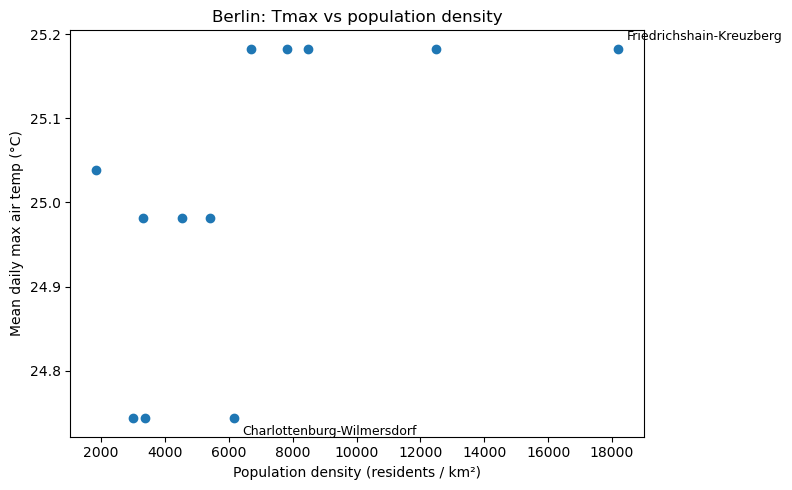

Saved:
 - /Users/medhanshahuja/Projects/Urban Technology/Urban_Heat_Berlin_Project/maps/scatter_tmax_vs_green.png
 - /Users/medhanshahuja/Projects/Urban Technology/Urban_Heat_Berlin_Project/maps/scatter_tmax_vs_density.png


In [33]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# --- robust repo root (works if your CWD is repo root OR repo_root/code) ---
ROOT = Path.cwd()
if not (ROOT / "data" / "processed").exists():
    ROOT = ROOT.parent  # likely you are in /code
if not (ROOT / "data" / "processed").exists():
    raise FileNotFoundError("Could not find data/processed. Open the repo root folder in VS Code.")

csv_path = ROOT / "data" / "processed" / "berlin_bezirke_uhi_features.csv"
maps_dir = ROOT / "maps"
maps_dir.mkdir(exist_ok=True)

df0 = pd.read_csv(csv_path)

# Columns we expect (based on the CSV you showed)
BEZ   = "name"
TMAX  = "mean_daily_max"
GREEN = "green_share_pct"
DENS  = "pop_density_ew_km2"

needed = [BEZ, TMAX, GREEN, DENS]
missing = [c for c in needed if c not in df0.columns]
if missing:
    raise KeyError(f"Missing columns in {csv_path}:\n{missing}\nAvailable:\n{list(df0.columns)}")

df = df0[needed].copy()
for c in [TMAX, GREEN, DENS]:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df = df.dropna()

corr_green = df[[TMAX, GREEN]].corr().iloc[0, 1]
corr_dens  = df[[TMAX, DENS]].corr().iloc[0, 1]
print(f"Pearson corr(Tmax, green_share_pct)     = {corr_green:.3f}")
print(f"Pearson corr(Tmax, pop_density_ew_km2)  = {corr_dens:.3f}")

def label_key(ax, dfx, xcol, ycol, labelcol):
    # label warmest, coolest, and most extreme-x (greenest/densest)
    idxs = [dfx[ycol].idxmax(), dfx[ycol].idxmin(), dfx[xcol].idxmax()]
    # de-duplicate while preserving order
    seen, uniq = set(), []
    for i in idxs:
        if i not in seen:
            seen.add(i)
            uniq.append(i)

    offsets = [(6, 6), (6, -12), (-80, 6), (-80, -12)]
    for k, i in enumerate(uniq):
        ax.annotate(
            str(dfx.loc[i, labelcol]),
            (dfx.loc[i, xcol], dfx.loc[i, ycol]),
            textcoords="offset points",
            xytext=offsets[k % len(offsets)],
            fontsize=9
        )

# ---- Plot 1: Tmax vs green share ----
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(df[GREEN], df[TMAX])
ax.set_xlabel("Green share (% of Bezirk area)")
ax.set_ylabel("Mean daily max air temp (°C)")
ax.set_title("Berlin: Tmax vs green share")
label_key(ax, df, GREEN, TMAX, BEZ)
fig.tight_layout()

out1 = maps_dir / "scatter_tmax_vs_green.png"
fig.savefig(out1, dpi=200, bbox_inches="tight")  # SAVE BEFORE SHOW
plt.show()
plt.close(fig)

# ---- Plot 2: Tmax vs density ----
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(df[DENS], df[TMAX])
ax.set_xlabel("Population density (residents / km²)")
ax.set_ylabel("Mean daily max air temp (°C)")
ax.set_title("Berlin: Tmax vs population density")
label_key(ax, df, DENS, TMAX, BEZ)
fig.tight_layout()

out2 = maps_dir / "scatter_tmax_vs_density.png"
fig.savefig(out2, dpi=200, bbox_inches="tight")  # SAVE BEFORE SHOW
plt.show()
plt.close(fig)

print("Saved:")
print(" -", out1)
print(" -", out2)


## ML (Ridge regression)

In [34]:
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import LeaveOneOut, cross_val_predict
from sklearn.metrics import mean_absolute_error, r2_score

# Load canonical processed output
csv_path = Path("..") / "data" / "processed" / "berlin_bezirke_uhi_features.csv"
df0 = pd.read_csv(csv_path)

# Features + target
target = "mean_daily_max"
features = ["green_share_pct", "pop_density_ew_km2"]

df = df0[["name", target] + features].copy()
for c in [target] + features:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df = df.dropna()

X = df[features].values
y = df[target].values

# Simple, defensible model for small N
model = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge(alpha=1.0))
])

loo = LeaveOneOut()
y_pred = cross_val_predict(model, X, y, cv=loo)

mae = mean_absolute_error(y, y_pred)
r2  = r2_score(y, y_pred)

print("LOOCV results (N=12):")
print("MAE:", round(mae, 3), "°C")
print("R² :", round(r2, 3))

# Fit final model on all data to report coefficients
model.fit(X, y)
coef = model.named_steps["ridge"].coef_
print("\nFinal fit coefficients (standardized features):")
for f, c in zip(features, coef):
    print(f"  {f}: {c:+.3f}")

# Show per-Bezirk predicted vs actual (helpful for discussion)
out = df[["name"]].copy()
out["actual_mean_daily_max"] = y
out["pred_mean_daily_max_LOOCV"] = y_pred
out["error"] = out["pred_mean_daily_max_LOOCV"] - out["actual_mean_daily_max"]
out.sort_values("error", ascending=False)

LOOCV results (N=12):
MAE: 0.141 °C
R² : 0.167

Final fit coefficients (standardized features):
  green_share_pct: +0.063
  pop_density_ew_km2: +0.063


,name,actual_mean_daily_max,pred_mean_daily_max_LOOCV,error
0,Charlottenburg-Wilmersdorf,24.743478,24.983259,0.239780
8,Spandau,24.743478,24.959063,0.215584
9,Steglitz-Zehlendorf,24.743478,24.941668,0.198190
3,Marzahn-Hellersdorf,24.981522,25.078740,0.097218
1,Friedrichshain-Kreuzberg,25.182609,25.261101,0.078492
4,Mitte,25.182609,25.223202,0.040594
6,Pankow,24.981522,24.931456,-0.050066
7,Reinickendorf,24.981522,24.889785,-0.091737
2,Lichtenberg,25.182609,25.065452,-0.117157
10,Tempelhof-Schöneberg,25.182609,25.044517,-0.138092
